<div style="display: top; background-image:url('https://d1.awsstatic.com/SageMaker/SageMaker%20reInvent%202020/ImgHead_Mohave.3b1df33baa5f71b53237bfa6911fb3adc4902c0e.png');background-position: center ;background-repeat: no-repeat;background-size: 100%; padding-top:20px;">
<div style="color:#FFFFFF; text-align: top;padding-bottom: 25px; padding-left: 15px"><h1 style="font-weight: 900;">Project DAY 2 - SOLUTION</h1>
</div>
</div>
<br>


In this notebook, we go over Random Forest Classifier to predict the __isPositive__ field of an Amazon Product Review dataset. 

1. <a href="#1">Read the dataset</a> (Given) 
2. <a href="#2">Train a model</a> (Implement)
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a>
    * <a href="#23">Data processing</a>
    * <a href="#24">Model training</a>
3. <a href="#3">Make predictions on the test dataset</a> (Implement)
4. <a href="#4">Evaluate accuracy</a> (Given)

__Amazon Product Review Dataset__:

In this exercise, we are working with a product review dataset from Amazon. The raw data is available [here](https://nijianmo.github.io/amazon/index.html). You can find this dataset under __DATA/product-reviews__ in two variants (for regression or classification task): 
* _Amazon_Reviews_Regression.csv_ 
* _Amazon_Reviews_Classification.csv_

__Dataset schema:__ 

| __reviewText__      | __summary__ | __verified__     | __time__ | __log_votes__ | __isPositive__ |
| :---        |    :----:   |       :----:   |      :----:   |      :----:   |         ---: |
| Full text of the product review      | Summary text of the review       | Verified purchase? (True or False)  | UNIX timestamp for the review | Logarithm-adjusted votes log(1+votes)  | Positive review? (1 - yes or 0 - no) |

__isPositive__ - This is the field to predict.


In [1]:
# # Upgrade dependencies
# !pip install --upgrade pip
# !pip install --upgrade scikit-learn

In [2]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, string
import nltk
from nltk.stem import SnowballStemmer
from sklearn import set_config

from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

## 1. <a name="1">Read the datasets</a> (Given)
(<a href="#0">Go to top</a>)

Let's read the datasets into dataframes, using Pandas.

In [3]:
# Read in the dataset
df = pd.read_csv("../../DATA/product-reviews/Amazon_Reviews_Classification.csv")

# We split between train and test data
training_data, test_data = train_test_split(df, test_size=0.15, random_state=1)

print("The shape of the training dataset is:", training_data.shape)
print("The shape of the test dataset is:", test_data.shape)

The shape of the training dataset is: (59500, 6)
The shape of the test dataset is: (10500, 6)


## 2. <a name="2">Train a model</a> (Implement)
(<a href="#0">Go to top</a>)

 * <a href="#21">Exploratory Data Analysis</a>
 * <a href="#22">Select features to build the model</a>
 * <a href="#23">Data processing</a>
 * <a href="#24">Model training</a>

### 2.1 <a name="21">Exploratory Data Analysis</a> 
(<a href="#2">Go to Train a model</a>)

Look at the number of rows, columns and some simple statistics of the dataset; `.head()` and `.info()` can help with this.

In [4]:
training_data.head(2)

reviewText  \
28204  Every year I upgrade. Guess I could skip it a ...   
5875   I have used TurboTax for the past four or five...   

                                summary  verified        time  log_votes  \
28204  Just my annual renewal as always     False  1391299200        0.0   
5875                 Helpful As Always!      True  1362268800        0.0   

       isPositive  
28204         1.0  
5875          1.0

In [5]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59500 entries, 28204 to 5192
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  59490 non-null  object 
 1   summary     59489 non-null  object 
 2   verified    59500 non-null  bool   
 3   time        59500 non-null  int64  
 4   log_votes   59500 non-null  float64
 5   isPositive  59500 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(2)
memory usage: 2.8+ MB


#### Model features vs model target
For further analysis seperate the model features from the target based on data type and using the information in the data schema.

In [6]:
# Split model target and features
model_target = "isPositive"  # 0 & 1
model_features = training_data.columns.drop(model_target).tolist()

Create the list of features (based on type). To split out numerical features for example:
    
`numerical_features = training_data[model_features].select_dtypes(include=np.number).columns`

We already know how to work with text and categorical features, so let's include those too.


In [7]:
# Split model features between categorical and numerical features
text_features = training_data.select_dtypes(include="object").columns.tolist()
numerical_features = (
    training_data.select_dtypes(include=np.number).columns.drop(model_target).tolist()
)
categorical_features = training_data.select_dtypes(include="bool").columns.tolist()

When working with text data, it is always good practice to cast the text columns to string. Make sure to do this for all splits of the dataset (train, validation & test).

In [8]:
training_data[text_features] = training_data[text_features].astype(str)
test_data[text_features] = test_data[text_features].astype(str)

Let's keep going with the EDA and plot histograms for all categorical features:

verified


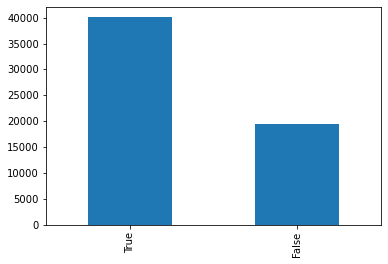

In [9]:
plt.figure(figsize=(6, 4))
for c in categorical_features:
    try:
        print(c)
        training_data[c].value_counts(sort=True)[
            :20
        ].plot.bar()  # only show 20 most frequent
        plt.show()
        plt.close()
    except:
        print("Could not plot feature %s" % c)
        pass

Let's keep going with the EDA and plot histograms for all text features:

reviewText


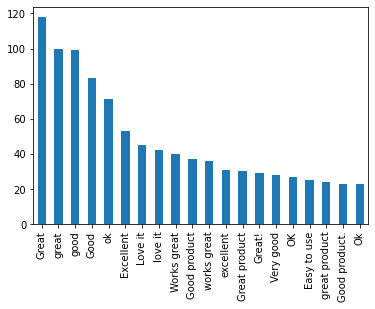

summary


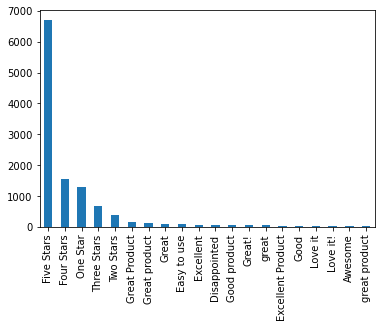

In [10]:
plt.figure(figsize=(6, 4))
for c in text_features:
    try:
        print(c)
        training_data[c].value_counts(sort=True)[
            :20
        ].plot.bar()  # only show 20 most frequent
        plt.show()
        plt.close()
    except:
        print("Could not plot feature %s" % c)
        pass

#### Target Distribution
Let's have a look at the number of instances of class 0 and 1 respectively by using `.value_counts()`.

<AxesSubplot:>

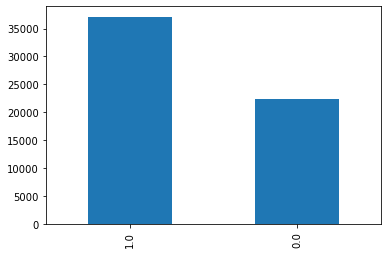

In [11]:
training_data[model_target].value_counts().plot.bar()

As the classes are imbalanced we want to upsample the underrepresented class.

In [12]:
print("Data set shape:", training_data.shape)

print("Class 0 samples in the data set:", sum(training_data[model_target] == 0))
print("Class 1 samples in the data set:", sum(training_data[model_target] == 1))

from sklearn.utils import shuffle

class_0_no = training_data[training_data[model_target] == 0]
class_1_no = training_data[training_data[model_target] == 1]

upsampled_class_0_no = class_0_no.sample(
    n=len(class_1_no), replace=True, random_state=42
)

training_data_upsampled = pd.concat([class_1_no, upsampled_class_0_no])
training_data_upsampled = shuffle(training_data_upsampled)

print("\nData set shape:", training_data_upsampled.shape)

print(
    "Class 0 samples in the data set:", sum(training_data_upsampled[model_target] == 0)
)
print(
    "Class 1 samples in the data set:", sum(training_data_upsampled[model_target] == 1)
)

Data set shape: (59500, 6)
Class 0 samples in the data set: 22367
Class 1 samples in the data set: 37133

Data set shape: (74266, 6)
Class 0 samples in the data set: 37133
Class 1 samples in the data set: 37133


#### Upsampled Data
To check that the upsampling worked as expected, let's plot the distribution again.

<AxesSubplot:>

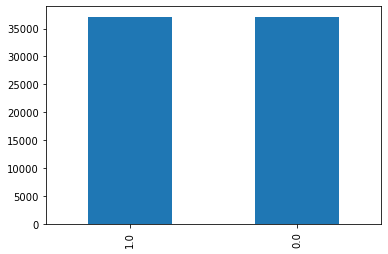

In [13]:
training_data_upsampled[model_target].value_counts().plot.bar()

### 2.2 <a name="22">Select features to build the model</a> 
(<a href="#2">Go to Train a model</a>)

Notice from EDA step that `time` is almost always unique and drop it from the features.

In [14]:
training_data_upsampled.drop(columns=["time"], inplace=True)
test_data.drop(columns=["time"], inplace=True)

In [15]:
# Also make sure to remove it from the feature list
numerical_features.remove("time")
model_features.remove("time")

### 2.3 <a name="23">Data Processing</a> 
(<a href="#2">Go to Train a model</a>)


During EDA we noticed a lot of similar words in the top most frequent values (they only differed by upper case/lower case). Hence, we want to clean our data before proceeding with the pipeline build.

In [16]:
# Prepare cleaning functions
stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

stemmer = SnowballStemmer("english")


def preProcessText(text):
    # lowercase and strip leading/trailing white space
    text = text.lower().strip()
    # remove punctuation
    text = re.compile("[%s]" % re.escape(string.punctuation)).sub(" ", text)
    # remove extra white space
    text = re.sub("\s+", " ", text)
    return text


def lexiconProcess(text, stop_words, stemmer):
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))
    text = " ".join(filtered_sentence)
    return text


def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)


# Clean the text features
for c in text_features:
    print("Text cleaning: ", c)
    training_data_upsampled[c] = [
        cleanSentence(item, stop_words, stemmer)
        for item in training_data_upsampled[c].values
    ]
    test_data[c] = [
        cleanSentence(item, stop_words, stemmer) for item in test_data[c].values
    ]

Text cleaning:  reviewText
Text cleaning:  summary


Try different scalers and imputers. Make sure to fill missing text values with e.g. `SimpleImputer(strategy='constant', fill_value = 'missing')`.

In [17]:
### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline(
    [
        ("num_imputer", SimpleImputer(strategy="mean")),
        (
            "num_scaler",
            MinMaxScaler(),
        ),  # Shown in case is needed, not a must with Decision Trees
    ]
)
# Preprocess the categorical features
categorical_processor = Pipeline(
    [
        (
            "cat_encoder",
            OneHotEncoder(handle_unknown="ignore"),
        )  # handle_unknown tells it to ignore (rather than throw an error for) any value that was not present in the initial training set.
    ]
)

# Preprocess text feature
text_processor = Pipeline(
    [("text_vect", CountVectorizer(binary=True, max_features=10))]
)

# Combine all data preprocessors from above (add more, if you choose to define more!)
# For each processor/step specify: a name, the actual process, and finally the features to be processed
data_preprocessor = ColumnTransformer(
    [
        ("numerical_pre", numerical_processor, numerical_features),
        ("categorical_pre", categorical_processor, categorical_features),
        ("text_pre_0", text_processor, text_features[0]),
        ("text_pre_1", text_processor, text_features[1]),
    ],
    remainder="drop",
)

### 2.4 <a name="24">Model training/fitting</a> 
(<a href="#2">Go to Train a model</a>)

Train the model below.

In [34]:
### PIPELINE ###
################

# Pipeline desired all data transformers, along with an estimator at the end
classifier = Pipeline(
    [("data_preprocessing", data_preprocessor), ("rf", RandomForestClassifier())]
)

# Create a new variable X_train based on upsampled data
X_train = training_data_upsampled
# Labels always remain the same - independent of features
y_train = training_data_upsampled[model_target]


# Fit the Pipeline to training data
classifier.fit(X_train, y_train);

In [19]:
# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
set_config(display="diagram")
classifier

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['log_votes']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['verified']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=10))]),
                                                  'reviewText'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=10))]),
                                                  'summary')])),
                ('rf', RandomForestClassifier())])

## 3. <a name="3">Make predictions on the test dataset</a> (Implement)
(<a href="#0">Go to top</a>)

Use the test set to make predictions with the trained model. *Beware*: The model here is called `classifier`; ensure to amend this as per model name used.

In [20]:
# Use the fitted model to make predictions on the test dataset
test_predictions = classifier.predict(test_data)

## 4. <a name="4">Evaluate accuracy</a> (Given)
(<a href="#0">Go to top</a>)

Use the Sklearn in-built reports to evaluate model accuracy on training and test data.

In [21]:
# Use the fitted model to make predictions on the train dataset
train_predictions = classifier.predict(X_train)

print("Model performance on the train set:")
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Train accuracy:", accuracy_score(y_train, train_predictions))

Model performance on the train set:
[[32511  4622]
 [ 5858 31275]]
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86     37133
         1.0       0.87      0.84      0.86     37133

    accuracy                           0.86     74266
   macro avg       0.86      0.86      0.86     74266
weighted avg       0.86      0.86      0.86     74266

Train accuracy: 0.8588856273395632


In [22]:
print("Model performance on the test set:")
print(confusion_matrix(test_data[model_target], test_predictions))
print(classification_report(test_data[model_target], test_predictions))
print("Test accuracy:", accuracy_score(test_data[model_target], test_predictions))

Model performance on the test set:
[[2595 1346]
 [1763 4796]]
              precision    recall  f1-score   support

         0.0       0.60      0.66      0.63      3941
         1.0       0.78      0.73      0.76      6559

    accuracy                           0.70     10500
   macro avg       0.69      0.69      0.69     10500
weighted avg       0.71      0.70      0.71     10500

Test accuracy: 0.7039047619047619


Let's look at [feature importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) for the model pipeline that contains only numerical features. In fact, there is only one numerical feature. The case for categorical features is non-trivial as part of the pipeline applies OneHot encoding which explodes the number of features.

In [23]:
forest = classifier.steps[1][1]
importances = forest.feature_importances_

std = np.std([forest.feature_importances_ for tree in forest.estimators_], axis=0)

In [24]:
ft_names = (
    numerical_features
    + list(
        classifier.named_steps["data_preprocessing"]
        .transformers_[1][1]
        .named_steps["cat_encoder"]
        .get_feature_names(categorical_features)
    )
    + list(
        classifier.named_steps["data_preprocessing"]
        .transformers_[2][1]
        .named_steps["text_vect"]
        .get_feature_names()
    )
    + list(
        classifier.named_steps["data_preprocessing"]
        .transformers_[3][1]
        .named_steps["text_vect"]
        .get_feature_names()
    )
)

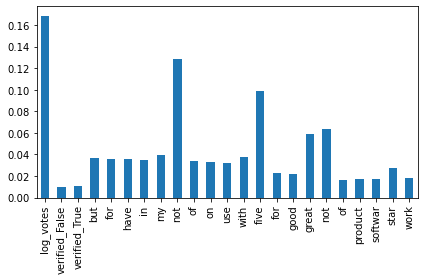

In [25]:
forest_importances = pd.Series(importances, index=ft_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
fig.tight_layout()

We notice that both text features end up generating similar outcomes, so we should only use one. Interestingly, 'not' and 'five' are important features. It seems that 'five' indicates 'five stars' and therefor refers to a very positive review.

## Hyperparameter Tuning

In [26]:
# Parameter grid for RandomizedSearchCV
param_grid = {"rf__n_estimators": [20], "rf__max_depth": [100, 200]}

rand_search = RandomizedSearchCV(
    classifier,  # Base model
    param_grid,  # Parameters to try
    cv=5,  # Apply 5-fold cross validation
    verbose=1,  # Print summary
    n_jobs=-1,  # Use all available processors
)

# Fit the GridSearch to our training data
rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('data_preprocessing',
                                              ColumnTransformer(transformers=[('numerical_pre',
                                                                               Pipeline(steps=[('num_imputer',
                                                                                                SimpleImputer()),
                                                                                               ('num_scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['log_votes']),
                                                                              ('categorical_pre',
                                                                               Pipeline(steps=[('cat_encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['verified']),
                                                                              ('text_pre_0',
                                                                               Pipeline(steps=[('text_vect',
                                                                                                CountVectorizer(binary=True,
                                                                                                                max_features=10))]),
                                                                               'reviewText'),
                                                                              ('text_pre_1',
                                                                               Pipeline(steps=[('text_vect',
                                                                                                CountVectorizer(binary=True,
                                                                                                                max_features=10))]),
                                                                               'summary')])),
                                             ('rf', RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'rf__max_depth': [100, 200],
                                        'rf__n_estimators': [20]},
                   verbose=1)

In [27]:
print(rand_search.best_params_)
print(rand_search.best_score_)

{'rf__n_estimators': 20, 'rf__max_depth': 100}
0.7699081926083735


In [28]:
# Get the best model out of GridSearchCV
classifier = rand_search.best_estimator_

# Fit the best model to the train data once more
classifier.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['log_votes']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['verified']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=10))]),
                                                  'reviewText'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=10))]),
                                                  'summary')])),
                ('rf', RandomForestClassifier(max_depth=100, n_estimators=20))])

In [29]:
### Implement here various types of hyperparameter tuning, e.g. BaysianSearch
### You will need to install scikit-optimize to import BayesSearchCV

In [30]:
!pip install -U -q scikit-optimize

In [31]:
from skopt import BayesSearchCV

# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    classifier,
    param_grid,
    n_iter=2,
    cv=5
)

In [32]:
# Fit Baysian Search to our training data
opt.fit(X_train, y_train)
print(opt.best_params_)
print(opt.best_score_)

OrderedDict([('rf__max_depth', 167), ('rf__n_estimators', 20)])
0.7692349515172844


In [33]:
### ADVANCED: try training and deploying a model to a SageMaker endpoint and use it to make predictions
### Copy 09_EMBK-XGB-SAGEMAKER notebook and simply replace the dataset 
### in the beginning (also update feature selection section).